### Introduction

This dataset contains anonymized data from patients seen at the Hospital Israelita Albert Einstein, at São Paulo, Brazil, and who had samples collected to perform the SARS-CoV-2 RT-PCR and additional laboratory tests during a visit to the hospital.

All data were anonymized following the best international practices and recommendations. All clinical data were standardized to have a mean of zero and a unit standard deviation.

* Souce: https://www.kaggle.com/datasets/einsteindata4u/covid19


**Task**: Predict confirmed COVID-19 cases among suspected cases.
Based on the results of laboratory tests commonly collected for a suspected COVID-19 case during a visit to the emergency room, would it be possible to predict the test result for SARS-Cov-2 (positive/negative)?

In [44]:
# # uncomment block to install dependencies: python3, pip, pandas, numpy, seaborn, matplotlib, tensorflow, sklearn
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install tensorflow
# !pip install sklearn

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns

DATA_PATH = './covid_sp_dataset.xlsx'
data = pd.read_excel(DATA_PATH)

The data has 5644 rows and 111 columns.

The percentage of missing values is: 88.1%
Percentage of positive cases: 9.9%


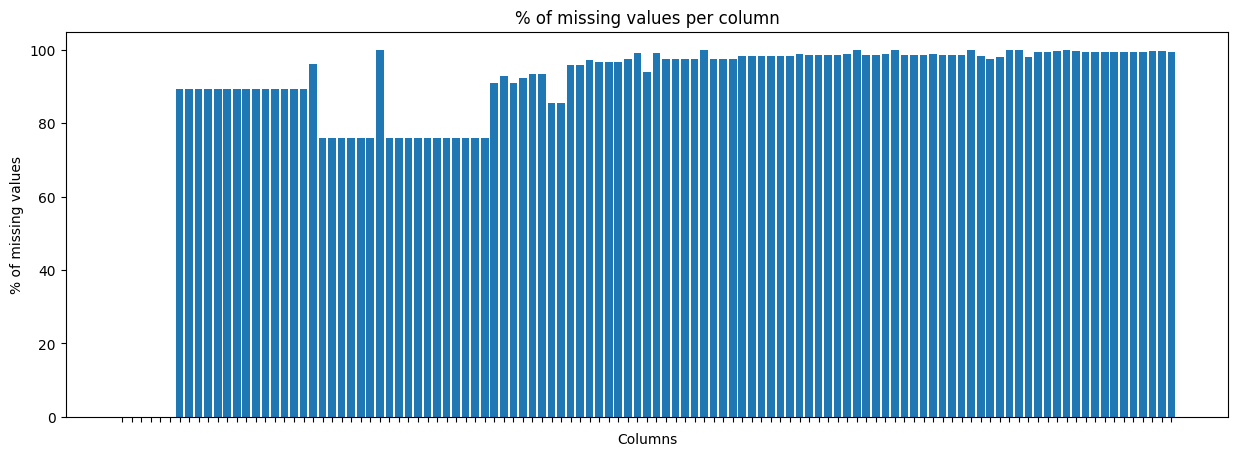

In [46]:
print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns.\n')
total_na_percentage = data.isna().sum().sum() / (data.shape[0] * data.shape[1]) * 100
print(f'The percentage of missing values is: {total_na_percentage:.1f}%')
print(f'Percentage of positive cases: {data["SARS-Cov-2 exam result"].value_counts()[1]/data.shape[0]*100:.1f}%')
fig, axes = plt.subplots(figsize=(15, 5))
axes.bar(data.columns, data.isna().sum()/data.shape[0]*100)
axes.set_title('% of missing values per column')
axes.set_xlabel('Columns')
axes.set_ylabel('% of missing values')
axes.set_xticklabels([])  # Hide x-axis labels
plt.show()

Checking the vacancies map

<Axes: >

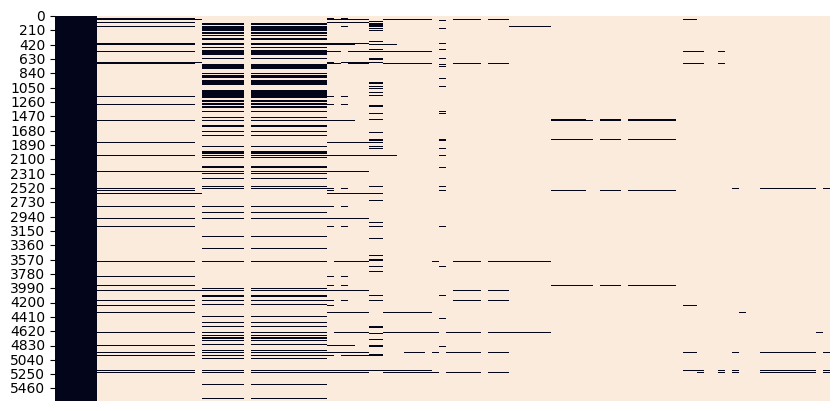

In [47]:
plt.figure(figsize=(10,5))
sns.heatmap(data.isna(), cbar=False, xticklabels=False)

### Data Cleaning

* Remove all atributes with less than 5% of present data

In [48]:
data.drop_duplicates(inplace=True)
for col_name, col in data.items():
    if data[col_name].isna().sum()/data.shape[0] > 0.95:
        data.drop([col_name], axis=1, inplace=True)

* Transform categorical classes into numeric classes 
* Consider missing data on categorical exams as negatives, since the med staff considered not necessary

In [49]:
bin_attributes = ['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1',
                'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3',
                'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E',
                'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2', 'Strepto A']

for col_name in bin_attributes:
    data[col_name].fillna('negative', inplace=True)

data.replace(to_replace='not_detected', value=int(0), inplace=True)
data.replace(to_replace='detected', value=int(1), inplace=True)
data.replace(to_replace='negative', value=int(0), inplace=True)
data.replace(to_replace='positive', value=int(1), inplace=True)


* Remove unecessary or duplicated atributes

In [50]:
data.drop(['Patient ID', 'Influenza A, rapid test', 'Influenza B, rapid test'], axis=1, inplace=True)

* Transform the 3 columns of Patient Admition into one (if later we decide to also predict this atribute)

In [51]:
patient_admition = data['Patient addmited to semi-intensive unit (1=yes, 0=no)'] * 2 + data['Patient addmited to intensive care unit (1=yes, 0=no)'] *3 + data['Patient addmited to regular ward (1=yes, 0=no)']
data.insert(3, 'Patient admition', patient_admition)
data.drop(['Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)', 'Patient addmited to regular ward (1=yes, 0=no)'], axis=1, inplace=True)

* Checking the density distribution among each interval atribute (mostly blood exams),  trying to find the most significant to P and N distribution.

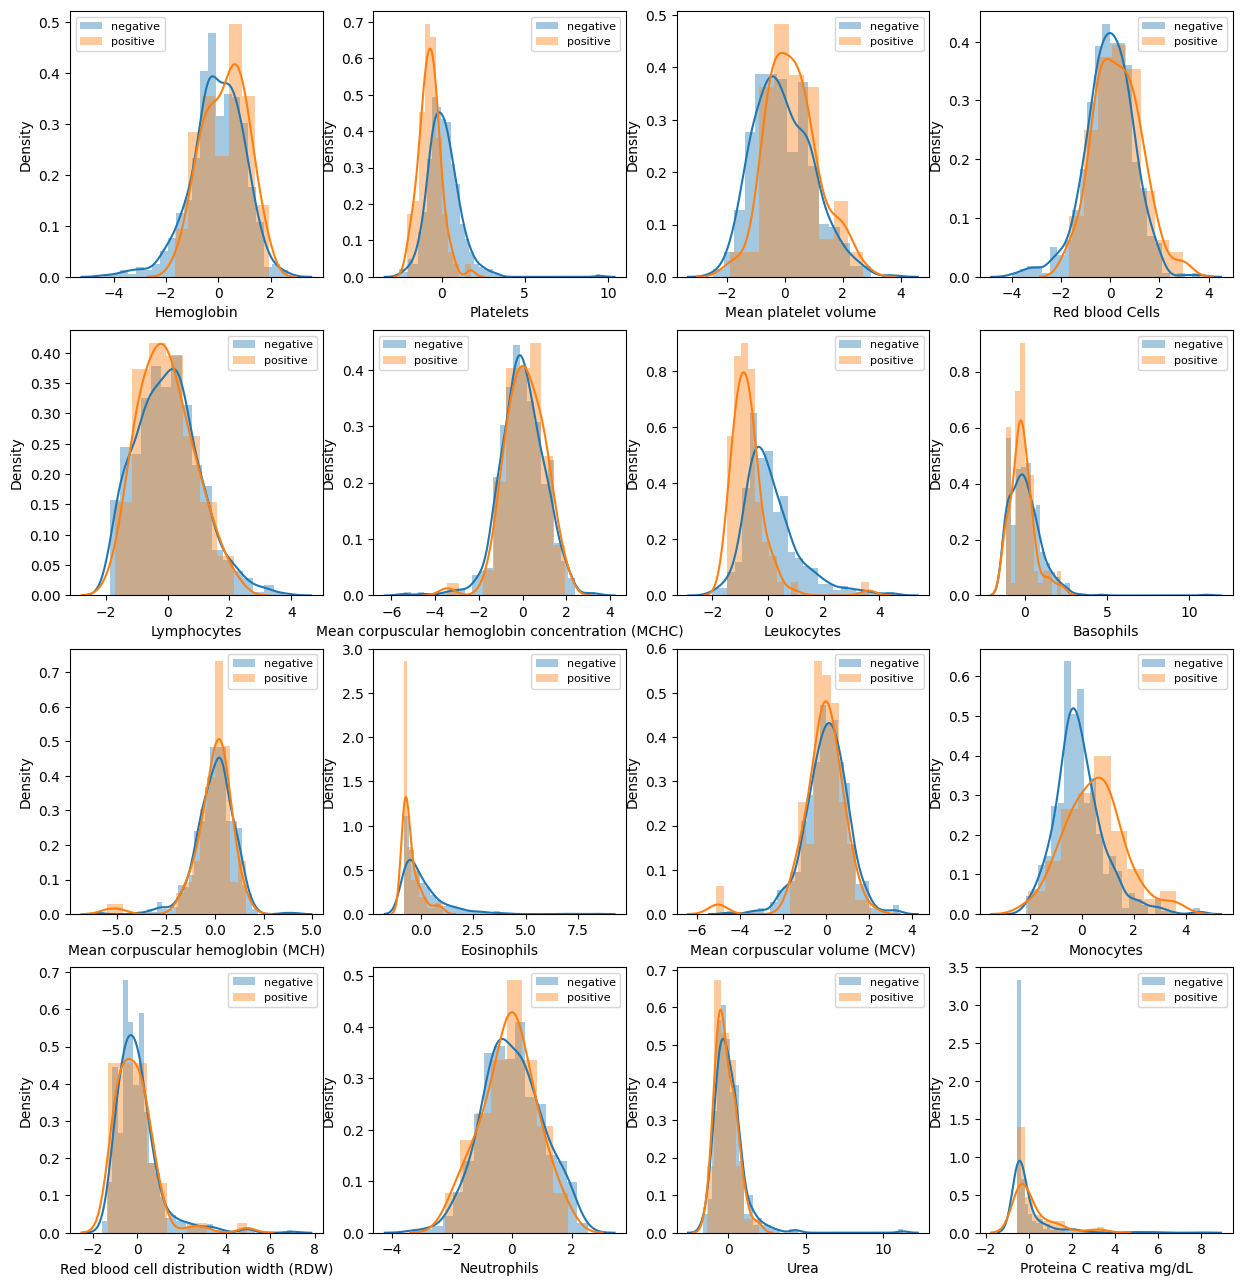

In [52]:
import warnings
warnings.filterwarnings("ignore")
columns = 4
rows = 5
fig=plt.figure(figsize=(15,20))
for i in range(1,len(data.select_dtypes("float").columns)-3):
    x = fig.add_subplot(rows, columns, i)
    sns.distplot(data[data['SARS-Cov-2 exam result']== 0][data.select_dtypes("float").columns[i]], label='negative')
    sns.distplot(data[data['SARS-Cov-2 exam result']== 1][data.select_dtypes("float").columns[i]], label='positive')
    x.legend(prop={'size': 8})

### Trying Two Diferent Strategies for Data Manipulation
Considering the density distribution, ploted above, we can see some particularly diferent distributions between positive and negative cases. That way, we decided to try two diferent approachs to the problem:
* cut all the rows that lack more than 80% of data - what has left with fewer cases and a bad positive/negative distribution, but less cases with none data;
* cut all the rows that lack more than 80% of data, **and are not positive cases** - what has left us with almost 50/50 distribution, but required more data filling.

The first one will be called ***data***, and the second and largest one ***data_large*** from now on in the code.

In [53]:
data_large = data.copy()

for row_index, row in data.iterrows():
    if row.isna().sum()/data.shape[1] > 0.20:
        data.drop([row_index], inplace=True)
data.reset_index(inplace=True, drop=True)

for row_index, row in data_large.iterrows():
    if row.isna().sum()/data.shape[1] > 0.20 and row['SARS-Cov-2 exam result'] == 0:
        data_large.drop([row_index], inplace=True)
data_large.reset_index(inplace=True, drop=True)

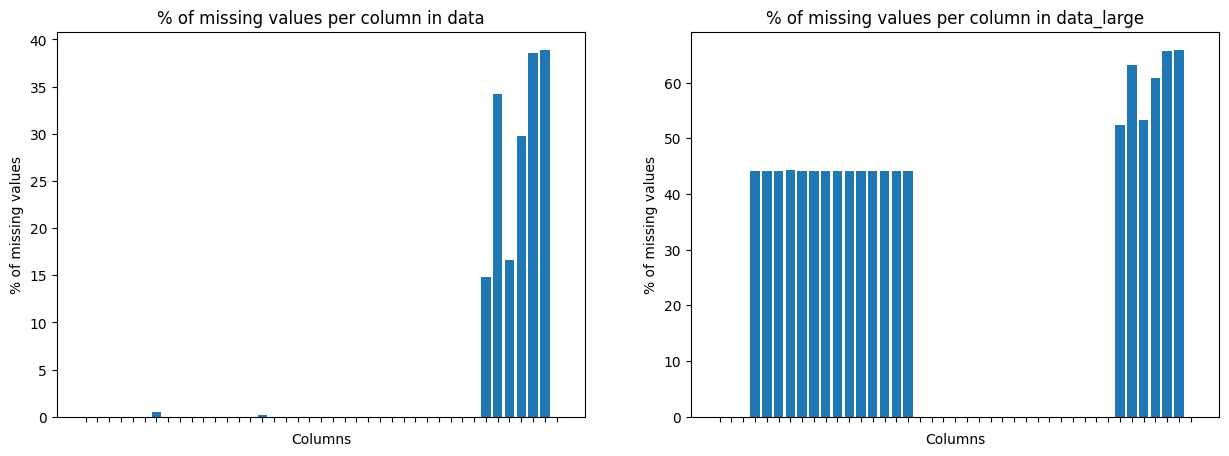

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].bar(data.columns, data.isna().sum()/data.shape[0]*100)
axes[0].set_title('% of missing values per column in data')
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('% of missing values')
axes[0].set_xticklabels([])  # Hide x-axis labels

axes[1].bar(data_large.columns, data_large.isna().sum()/data_large.shape[0]*100)
axes[1].set_title('% of missing values per column in data_large')
axes[1].set_xlabel('Columns')
axes[1].set_ylabel('% of missing values')
axes[1].set_xticklabels([])  # Hide x-axis labels

plt.xticks(rotation=90)
plt.show()

To fill the ramaining NaN entries, we decided to use the mean value, since all the atributes with NaN cases are float dtypes.

But, to maintain the distribution profile of P and N cases accros the atributes, we used the positive cases mean for each positive row in every column, and the same for negative cases. Mekr even more evidently the diferences.

In [55]:
data.loc[data['SARS-Cov-2 exam result'] == 1] = data[data['SARS-Cov-2 exam result'] == 1].fillna(data[data['SARS-Cov-2 exam result'] == 1].mean())
data.loc[data['SARS-Cov-2 exam result'] == 0] = data[data['SARS-Cov-2 exam result'] == 0].fillna(data[data['SARS-Cov-2 exam result'] == 0].mean())

data_large.loc[data_large['SARS-Cov-2 exam result'] == 1] = data_large[data_large['SARS-Cov-2 exam result'] == 1].fillna(data_large[data_large['SARS-Cov-2 exam result'] == 1].mean())
data_large.loc[data_large['SARS-Cov-2 exam result'] == 0] = data_large[data_large['SARS-Cov-2 exam result'] == 0].fillna(data_large[data_large['SARS-Cov-2 exam result'] == 0].mean())


Analysing the data distribution for both problems after filling the empty boxes. We are plotting the more evidently different distributions based on the pre-trimm data:
* platelets
* leukocytes
* monocytes
* proteina C reativa

The data has 602 rows and 41 columns.

The percentage of missing values is: 0.0%


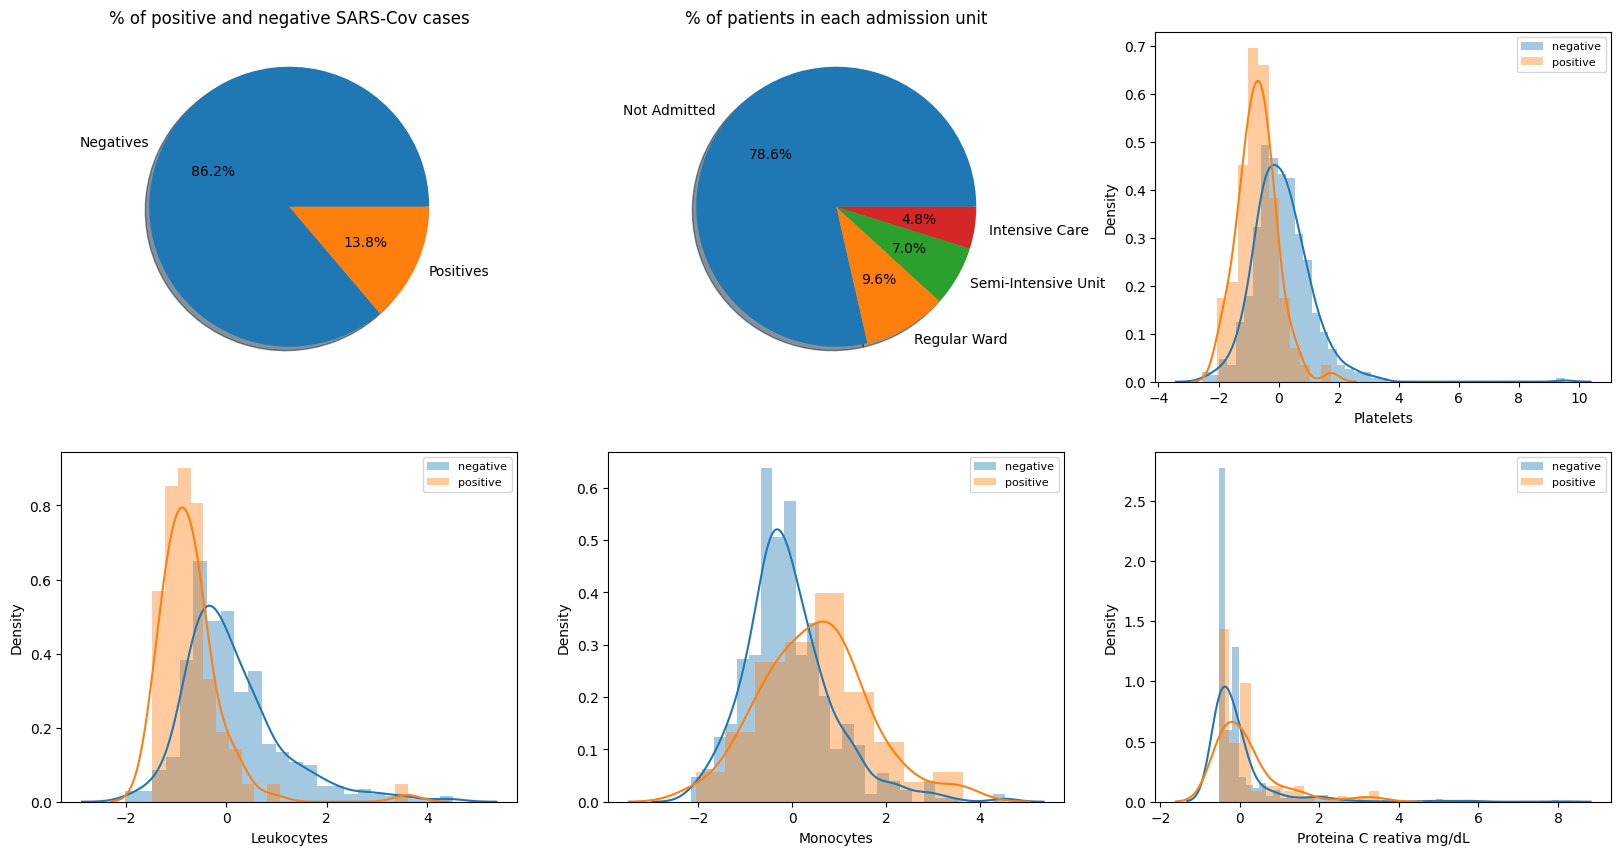

In [56]:
to_be_ploted = ['Platelets', 'Leukocytes', 'Monocytes',  'Proteina C reativa mg/dL']

columns = 3
rows = 2
fig=plt.figure(figsize=(20,10))
x = fig.add_subplot(rows, columns, 1)
sizes = [data['SARS-Cov-2 exam result'].value_counts()[0], data['SARS-Cov-2 exam result'].value_counts()[1]]
labels = ['Negatives', 'Positives']
x.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
x.set_title('% of positive and negative SARS-Cov cases')

x = fig.add_subplot(rows, columns, 2)
labels = ['Not Admitted', 'Regular Ward', 'Semi-Intensive Unit', 'Intensive Care']
sizes = [data['Patient admition'].value_counts()[0], data['Patient admition'].value_counts()[1], data['Patient admition'].value_counts()[2], data['Patient admition'].value_counts()[3]]
x.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
x.set_title('% of patients in each admission unit')

for i, atribute in enumerate(to_be_ploted, 1):
    x = fig.add_subplot(rows, columns, i+2)
    sns.distplot(data[data['SARS-Cov-2 exam result']== 0][atribute], label='negative')
    sns.distplot(data[data['SARS-Cov-2 exam result']== 1][atribute], label='positive')
    x.legend(prop={'size': 8})

print(f'The data has {data.shape[0]} rows and {data.shape[1]} columns.\n')
total_na_percentage = data.isna().sum().sum() / (data.shape[0] * data.shape[1]) * 100
print(f'The percentage of missing values is: {total_na_percentage:.1f}%')

The data has 1077 rows and 41 columns.

The percentage of missing values is: 0.0%


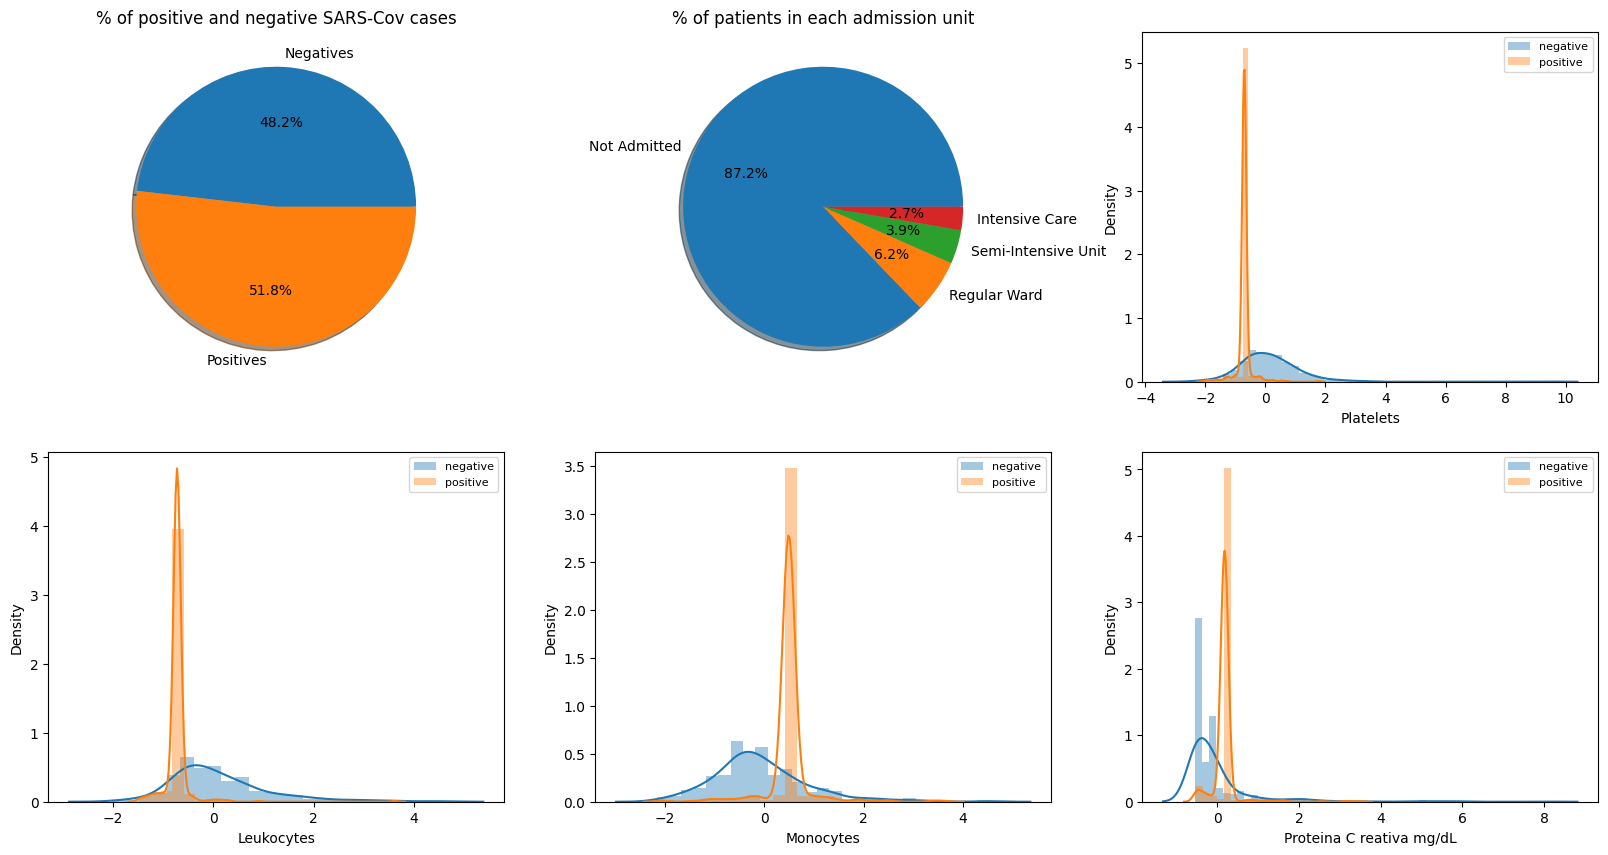

In [57]:
to_be_ploted = ['Platelets', 'Leukocytes', 'Monocytes',  'Proteina C reativa mg/dL']

columns = 3
rows = 2
fig=plt.figure(figsize=(20,10))
x = fig.add_subplot(rows, columns, 1)
sizes = [data_large['SARS-Cov-2 exam result'].value_counts()[0], data_large['SARS-Cov-2 exam result'].value_counts()[1]]
labels = ['Negatives', 'Positives']
x.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
x.set_title('% of positive and negative SARS-Cov cases')

x = fig.add_subplot(rows, columns, 2)
labels = ['Not Admitted', 'Regular Ward', 'Semi-Intensive Unit', 'Intensive Care']
sizes = [data_large['Patient admition'].value_counts()[0], data_large['Patient admition'].value_counts()[1], data_large['Patient admition'].value_counts()[2], data_large['Patient admition'].value_counts()[3]]
x.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
x.set_title('% of patients in each admission unit')

for i, atribute in enumerate(to_be_ploted, 1):
    x = fig.add_subplot(rows, columns, i+2)
    sns.distplot(data_large[data_large['SARS-Cov-2 exam result']== 0][atribute], label='negative')
    sns.distplot(data_large[data_large['SARS-Cov-2 exam result']== 1][atribute], label='positive')
    x.legend(prop={'size': 8})

print(f'The data has {data_large.shape[0]} rows and {data_large.shape[1]} columns.\n')
total_na_percentage = data_large.isna().sum().sum() / (data_large.shape[0] * data_large.shape[1]) * 100
print(f'The percentage of missing values is: {total_na_percentage:.1f}%')

### Data organization
* Split target for both problems (Covid result and patient admition)
* MinMax scalling of data (data is already normalized)
* Creating specifc dataframes for each problem, to be separated into x and y by KFold

In [58]:
data_y_sars = data.iloc[:, 1]
data_y_admition = data.iloc[:, 2]
data_x = data.drop(['SARS-Cov-2 exam result', 'Patient admition'], axis=1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
for col_name, col in data_x.items():
    data_x[col_name] = scaler.fit_transform(data_x[col_name].values.reshape(-1,1))

sars_data = pd.concat([data_x, data_y_sars], axis=1)
admition_data = pd.concat([data_x, data_y_admition], axis=1)

########################################### DATA_LARGE ###########################################

data_y_sars_large = data_large.iloc[:, 1]
data_y_admition_large = data_large.iloc[:, 2]
data_x_large = data_large.drop(['SARS-Cov-2 exam result', 'Patient admition'], axis=1)

for col_name, col in data_x_large.items():
    data_x_large[col_name] = scaler.fit_transform(data_x_large[col_name].values.reshape(-1,1))

sars_data_large = pd.concat([data_x_large, data_y_sars_large], axis=1)
admition_data_large = pd.concat([data_x_large, data_y_admition_large], axis=1)

* Using KFold Cross Validation

In [59]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=13)

* Defining evaluation for model fit and scores and cross_validation for kfold and train-test division within each fold

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def evaluate(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)
    recall = recall_score(y_test, y_predicted)
    acc = accuracy_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted)
    return acc, recall, f1

def cross_validation(kf, model, data):
    acc = []
    recall = []
    f1 = []
    for train_index, test_index in kf.split(data):
        x_train, x_test = data.iloc[train_index, :-1], data.iloc[test_index, :-1]
        y_train, y_test = data.iloc[train_index, -1], data.iloc[test_index, -1]
        acc_, recall_, f1_ = evaluate(model, x_train, x_test, y_train, y_test)
        acc.append(acc_)
        recall.append(recall_)
        f1.append(f1_)
    print(f'Model Params = {model.get_params()}')
    print(f'Accuracy = {np.mean(acc):.3f} +/- {np.std(acc):.3f}')
    print(f'Recall = {np.mean(recall):.3f} +/- {np.std(recall):.3f}')
    print(f'F1 = {np.mean(f1):.3f} +/- {np.std(f1):.3f}')
    print(f'Best Accuracy = {np.max(acc):.3f}')
    print(f'Best Recall = {np.max(recall):.3f}')
    print(f'Best F1 = {np.max(f1):.3f}')
    return np.mean(acc), np.mean(recall), np.mean(f1), np.max(acc), np.max(recall), np.max(f1)

In [61]:
models = []
acc_results = []
recall_results = []
f1_results = []

models_large = []
acc_results_large = []
recall_results_large = []
f1_results_large = []

### K Nearest Neighbors

* Creating the model

In [62]:
knn_model = KNeighborsClassifier(n_neighbors=5)

* Trainning model on *data*

In [63]:
acc_knn, recall_knn, f1_knn, max_acc_knn, max_recall_knn, max_f1_knn = cross_validation(kf, knn_model, sars_data)
models.append('KNN')
acc_results.append(max_acc_knn)
recall_results.append(max_recall_knn)
f1_results.append(max_f1_knn)

Model Params = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Accuracy = 0.864 +/- 0.031
Recall = 0.295 +/- 0.100
F1 = 0.370 +/- 0.137
Best Accuracy = 0.893
Best Recall = 0.389
Best F1 = 0.519


* Trainning model on *data_large*

In [64]:
acc_knn, recall_knn, f1_knn, max_acc_knn, max_recall_knn, max_f1_knn = cross_validation(kf, knn_model, sars_data_large)
models_large.append('KNN')
acc_results_large.append(max_acc_knn)
recall_results_large.append(max_recall_knn) 
f1_results_large.append(max_f1_knn)

Model Params = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Accuracy = 0.918 +/- 0.031
Recall = 0.924 +/- 0.035
F1 = 0.922 +/- 0.029
Best Accuracy = 0.953
Best Recall = 0.961
Best F1 = 0.952


### Decision Tree Classifier

In [65]:
dtc_model = DecisionTreeClassifier(random_state=13)

* Trainning model on *data*

In [66]:
acc_dtc, recall_dtc, f1_dtc, max_acc_dtc, max_recall_dtc, max_f1_dtc = cross_validation(kf, dtc_model, sars_data)
models.append('DTC')
acc_results.append(max_acc_dtc)
recall_results.append(max_recall_dtc)
f1_results.append(max_f1_dtc)

Model Params = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 13, 'splitter': 'best'}
Accuracy = 0.864 +/- 0.022
Recall = 0.468 +/- 0.111
F1 = 0.473 +/- 0.084
Best Accuracy = 0.892
Best Recall = 0.632
Best F1 = 0.615


* Trainning model on *data_large*

In [67]:
acc_dtc, recall_dtc, f1_dtc, max_acc_dtc, max_recall_dtc, max_f1_dtc = cross_validation(kf, dtc_model, sars_data_large)
models_large.append('DTC')
acc_results_large.append(max_acc_dtc)
recall_results_large.append(max_recall_dtc)
f1_results_large.append(max_f1_dtc)

Model Params = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 13, 'splitter': 'best'}
Accuracy = 0.916 +/- 0.008
Recall = 0.918 +/- 0.028
F1 = 0.919 +/- 0.005
Best Accuracy = 0.926
Best Recall = 0.956
Best F1 = 0.927


### Multi Layer Perceptron

In [68]:
mlp_model = MLPClassifier(hidden_layer_sizes=[50, 50, 50], activation='relu', solver ='adam', max_iter=10000000, learning_rate_init=0.1, alpha=0.02, learning_rate='adaptive')

* Trainning model on *data*

In [69]:
acc_mlp, recall_mlp, f1_mlp, max_acc_mlp, max_recall_mlp, max_f1_mlp = cross_validation(kf, mlp_model, sars_data)
models.append('SKL_MLP')
acc_results.append(max_acc_mlp)
recall_results.append(max_recall_mlp)
f1_results.append(max_f1_mlp)

Model Params = {'activation': 'relu', 'alpha': 0.02, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': [50, 50, 50], 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'max_fun': 15000, 'max_iter': 10000000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Accuracy = 0.869 +/- 0.043
Recall = 0.547 +/- 0.305
F1 = 0.473 +/- 0.243
Best Accuracy = 0.933
Best Recall = 0.833
Best F1 = 0.667


* Trainning model on *data_large*

In [70]:
acc_mlp, recall_mlp, f1_mlp, max_acc_mlp, max_recall_mlp, max_f1_mlp = cross_validation(kf, mlp_model, sars_data_large)
models_large.append('SKL_MLP')
acc_results_large.append(max_acc_mlp)
recall_results_large.append(max_recall_mlp)
f1_results_large.append(max_f1_mlp)

Model Params = {'activation': 'relu', 'alpha': 0.02, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': [50, 50, 50], 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'max_fun': 15000, 'max_iter': 10000000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Accuracy = 0.854 +/- 0.130
Recall = 0.958 +/- 0.023
F1 = 0.885 +/- 0.076
Best Accuracy = 0.940
Best Recall = 1.000
Best F1 = 0.937


### Random Forest Classifier

In [71]:
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=10)

* Trainning model on *data*

In [72]:
acc_rfc, recall_rfc, f1_rfc, max_acc_rfc, max_recall_rfc, max_f1_rfc = cross_validation(kf, rfc_model, sars_data)
models.append('RFC')
acc_results.append(max_acc_rfc)
recall_results.append(max_recall_rfc)
f1_results.append(max_f1_rfc)

Model Params = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Accuracy = 0.904 +/- 0.026
Recall = 0.359 +/- 0.071
F1 = 0.502 +/- 0.074
Best Accuracy = 0.942
Best Recall = 0.500
Best F1 = 0.643


* Trainning model on *data_large*

In [73]:
acc_rfc, recall_rfc, f1_rfc, max_acc_rfc, max_recall_rfc, max_f1_rfc = cross_validation(kf, rfc_model, sars_data_large)
models_large.append('RFC')
acc_results_large.append(max_acc_rfc)
recall_results_large.append(max_recall_rfc)
f1_results_large.append(max_f1_rfc)

Model Params = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Accuracy = 0.943 +/- 0.017
Recall = 0.900 +/- 0.035
F1 = 0.942 +/- 0.017
Best Accuracy = 0.963
Best Recall = 0.941
Best F1 = 0.963


Using SKLearn, this was the best result that we could achieve. And it follows the expected considering the lack of data on the dataset.

As a comparison, the following implementation on kaggle more shy results (with the best F1 score of 0.574): https://www.kaggle.com/code/aurbcd/covid19-data-science-exercise

### Using Tensor Flow

Creating the model

In [74]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from keras import backend as K

model = Sequential()
model.add(Dense(90, input_dim=sars_data.shape[1]-1, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['Accuracy', 'Recall', 'Precision'])

In [75]:
from sklearn.metrics import confusion_matrix,classification_report

def evaluate_tf(model, x_train, x_test, y_train, y_test, batch_size, epochs):
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(x_test, y_test))
    uu, acc, recall, precision = model.evaluate(x_test, y_test, verbose=0 )
    f1 = 2 * (precision * recall) / (precision + recall)
    return acc, recall, f1


def cross_validation_tf(kf, model, data, batch_size, epochs):
    acc = []
    recall = []
    f1 = []
    for train_index, test_index in kf.split(data):
        x_train, x_test = data.iloc[train_index, :-1], data.iloc[test_index, :-1]
        y_train, y_test = data.iloc[train_index, -1], data.iloc[test_index, -1]
        acc_, recall_, f1_ = evaluate_tf(model, x_train, x_test, y_train, y_test, batch_size, epochs)
        acc.append(acc_)
        recall.append(recall_)
        f1.append(f1_)
    print(f'acc = {np.mean(acc):.3f} +/- {np.std(acc):.3f}')
    print(f'recall = {np.mean(recall):.3f} +/- {np.std(recall):.3f}')
    print(f'f1 = {np.mean(f1):.3f} +/- {np.std(f1):.3f}')
    print(f'Best acc = {np.max(acc):.3f}')
    print(f'Best recall = {np.max(recall):.3f}')
    print(f'Best f1 = {np.max(f1):.3f}')
    return np.mean(acc), np.mean(recall), np.mean(f1), np.max(acc), np.max(recall), np.max(f1)

BATCH_SIZE = 32
EPOCHS = 500

* Trainning model on *data*

In [76]:
acc_tf, recall_tf, f1_tf, max_acc_tf, max_recall_tf, max_f1_tf = cross_validation_tf(kf, model, sars_data, BATCH_SIZE, EPOCHS)
models.append('TF_MLP')
acc_results.append(max_acc_tf)
recall_results.append(max_recall_tf)
f1_results.append(max_f1_tf)

acc = 0.940 +/- 0.026
recall = 0.708 +/- 0.080
f1 = 0.762 +/- 0.088
Best acc = 0.967
Best recall = 0.812
Best f1 = 0.867


* Trainning model on *data_large*

In [77]:
acc_tf, recall_tf, f1_tf, max_acc_tf, max_recall_tf, max_f1_tf = cross_validation_tf(kf, model, sars_data_large, BATCH_SIZE, EPOCHS)
models_large.append('TF_MLP')
acc_results_large.append(max_acc_tf)
recall_results_large.append(max_recall_tf)
f1_results_large.append(max_f1_tf)

print(max_recall_tf)

print(recall_results_large)

acc = 0.975 +/- 0.017
recall = 0.971 +/- 0.019
f1 = 0.975 +/- 0.018
Best acc = 0.991
Best recall = 1.000
Best f1 = 0.991
1.0
[0.9611650485436893, 0.9557522123893806, 1.0, 0.940677966101695, 1.0]


### Analysing the final results
We can see that the models using *data_large* have a better outcome in model trainning, given the few data that we have to work with. 

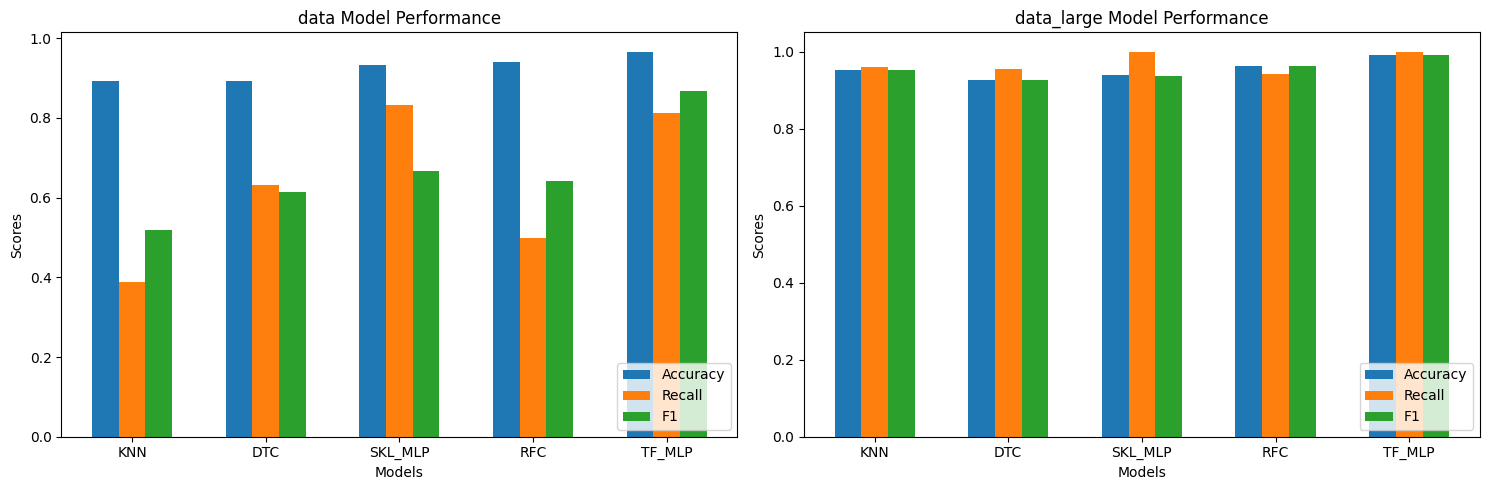

data                               data_large                      \
     Model  Accuracy    Recall        F1      Model  Accuracy    Recall   
0      KNN  0.892562  0.388889  0.518519        KNN  0.953488  0.961165   
1      DTC  0.891667  0.631579  0.615385        DTC  0.925926  0.955752   
2  SKL_MLP  0.933333  0.833333  0.666667    SKL_MLP  0.939535  1.000000   
3      RFC  0.941667  0.500000  0.642857        RFC  0.962791  0.940678   
4   TF_MLP  0.966667  0.812500  0.866667     TF_MLP  0.990698  1.000000   

             
         F1  
0  0.951923  
1  0.927039  
2  0.937198  
3  0.963303  
4  0.991228

In [79]:
results = pd.DataFrame({'Model': models, 'Accuracy': acc_results, 'Recall': recall_results, 'F1': f1_results})
results_large = pd.DataFrame({'Model': models_large, 'Accuracy': acc_results_large, 'Recall': recall_results_large, 'F1': f1_results_large})
final = pd.concat([results, results_large], axis=1, keys=['data', 'data_large'])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

bar_width = 0.2
bar1 = np.arange(len(results['Model']))
bar2 = [x + bar_width for x in bar1]
bar3 = [x + bar_width for x in bar2]

ax1.bar(bar1, results['Accuracy'], width=bar_width, label='Accuracy')
ax1.bar(bar2, results['Recall'],  width=bar_width, label='Recall')
ax1.bar(bar3, results['F1'],  width=bar_width, label='F1')
ax1.set_xticks([r + bar_width for r in range(len(results['Accuracy']))])
ax1.set_xticklabels(results['Model'])
ax1.set_title('data Model Performance')
ax1.set_xlabel('Models')
ax1.set_ylabel('Scores')
ax1.legend(loc='lower right')

ax2.bar(bar1, results_large['Accuracy'], width=bar_width, label='Accuracy')
ax2.bar(bar2, results_large['Recall'],  width=bar_width, label='Recall')
ax2.bar(bar3, results_large['F1'],  width=bar_width, label='F1')
ax2.set_xticks([r + bar_width for r in range(len(results_large['Accuracy']))])
ax2.set_xticklabels(results_large['Model'])
ax2.set_title('data_large Model Performance')
ax2.set_xlabel('Models')
ax2.set_ylabel('Scores')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

final
